Re-running the graph witness notebook with refractored code

In [1]:
import qcdenoise as qcd
import matplotlib.pyplot as plt
import qiskit as qk
import numpy as np
import networkx as nx

import os

Global seed set to 1234


In [2]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### 1. Building Quantum Circuit from Graph States Database


#### Load the default graph state database

This is the corpus from which subgraphs are drawn and combined to form random graphs

qcdenoise.graph_data- 06/18/2021 16:35:36 - INFO - Building database with Graphs from Hein et al. 


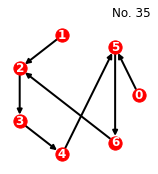

{'G': <networkx.classes.digraph.DiGraph at 0x7faa18c09310>,
 'V': 7,
 'LUclass': None,
 '2Color': None}

In [3]:
graph_db = qcd.GraphDB(directed=True)
graph_db.plot_graph(graph_number=[35])
graph_db['35']

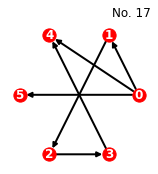

{'G': <networkx.classes.digraph.DiGraph at 0x7fa9f81c5970>,
 'V': 6,
 'LUclass': None,
 '2Color': None}

In [4]:
graph_db.plot_graph(graph_number=[17])
graph_db['17']

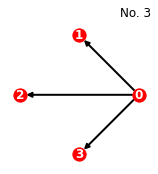

{'G': <networkx.classes.digraph.DiGraph at 0x7fa9f81dd520>,
 'V': 4,
 'LUclass': None,
 '2Color': None}

In [5]:
graph_db.plot_graph(graph_number=[3])
graph_db['3']

#### Initiate a q-circuit builder from graph states

Build a random graph on 4 qubits with undirected edges

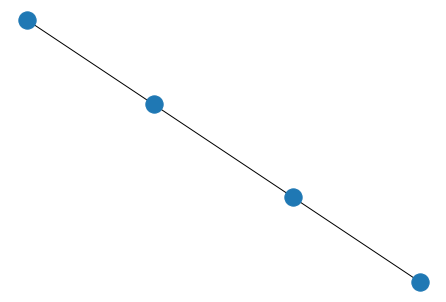

In [8]:
n_qubits=4
graph_state = qcd.GraphState(graph_db=graph_db, n_qubits=n_qubits)
g = graph_state.sample()
nx.draw(g)

In [13]:
circ_builder = qcd.CXGateCircuit(n_qubits=n_qubits,stochastic=False)

In [14]:
circ_builder.stochastic

False

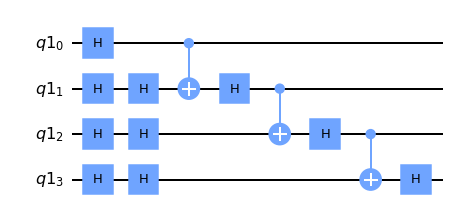

In [15]:
circ_builder.build(g)["circuit"].draw(output='mpl')

In [16]:
base_circuit = circ_builder.circuit

Once the circuit builder is initialized, and the base circuit is constructed- then the generators and stabilizer operators can be built

Calling `TothStabilizer` or `JungStabilizer` will build the sub-circuits needed to measure each stabilizer (Pauli string)

**Note** the generators and stabilizers will depend on the neighborhoods of each vertex and what is defined as a neighbor is dependent on the `NetworkX` graph structure.  If the edges are directed (pass `directed=True` inside `GraphConstructor`) then only vertices connected by a directed arc that ternminates at vertex (i) is a neighbor of (i).  On the other hand, if the graph is undirected (the default is `directed=False`) then any vertex connected by an edge to vertex (i) is a neighbor.

In [17]:
stabilizer = qcd.TothStabilizer(g, n_qubits=n_qubits)

In [18]:
stab_ops = stabilizer.find_stabilizers()

In [19]:
stabilizer_circuit_dict = stabilizer.build()

In [20]:
stabilizer_circuit_dict

OrderedDict([('IZXZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7faa3918ca90>),
             ('ZXZI',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7faa29b1ef40>),
             ('XZII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fa9f8afd760>),
             ('IIZX',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fa9f8afd670>),
             ('IIII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fa9e96a7520>)])

The keys of the `circuit_dict` are the associated Pauli strings to measure-- comparing the keys to the graph `g` above, they are correctly defined

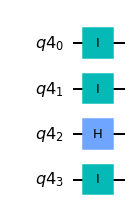

In [15]:
stabilizer_circuit_dict['ZXIZ'].draw(output='mpl')

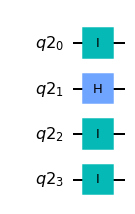

In [16]:
stabilizer_circuit_dict['IIXZ'].draw(output='mpl')

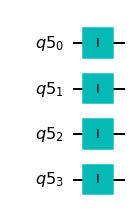

In [17]:
stabilizer_circuit_dict['IIII'].draw(output='mpl')

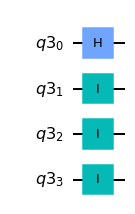

In [18]:
stabilizer_circuit_dict['IZZX'].draw(output='mpl')

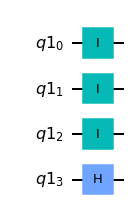

In [19]:
stabilizer_circuit_dict['XZII'].draw(output='mpl')

_there is something wrong with the stabilizer construction the initial Pauli operator is being dropped_

**Current Workaround** when the stabilizer strings are built using `find_stabilizers` followed by `get_unique_stabilizers`, the leading sign coefficient is dropped, using `drop_coef=True` will then result in a Pauli operator getting dropped.  Current workaround sets the default value of `drop_coef=False`.

Stabilizer stubs are correctly built with this workaround

In [20]:
stabilizer_circuit_dict

OrderedDict([('XZII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf81631190>),
             ('IIXZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf816312e0>),
             ('IZZX',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf816311f0>),
             ('ZXIZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf81631220>),
             ('IIII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf816310a0>)])

##### Build and mesure stabilizer circuits

pass the dictionary of stabilier sub-circuits and the base circuit

In [26]:
from qiskit.test.mock import FakeValencia, FakeTokyo, FakeMontreal
from qiskit.providers.aer.noise import NoiseModel

In [27]:
sampler = qcd.StabilizerSampler(n_shots=1024, backend=FakeMontreal())

In [28]:
ideal_counts = sampler.sample(stabilizer_circuits=stabilizer_circuit_dict,
                            graph_circuit=base_circuit)

qcdenoise.samplers- 06/18/2021 16:37:35 - INFO - Transpiling circuit and generating the circuit DAG
INFO:qcdenoise.samplers:Transpiling circuit and generating the circuit DAG
qcdenoise.samplers- 06/18/2021 16:37:35 - INFO - Simulating Circuit on AerSimulator
INFO:qcdenoise.samplers:Simulating Circuit on AerSimulator
qcdenoise.samplers- 06/18/2021 16:37:37 - INFO - Aer Simulator from backend:fake_montreal
INFO:qcdenoise.samplers:Aer Simulator from backend:fake_montreal
qcdenoise.samplers- 06/18/2021 16:37:37 - INFO - Simulation: Ideal, w/o noise_model
INFO:qcdenoise.samplers:Simulation: Ideal, w/o noise_model


In [29]:
ideal_counts

[{'0101': 124,
  '0011': 139,
  '1011': 139,
  '1000': 119,
  '1110': 135,
  '0000': 131,
  '0110': 121,
  '1101': 116},
 {'0000': 132,
  '1101': 128,
  '1010': 127,
  '1011': 136,
  '0111': 138,
  '1100': 108,
  '0110': 118,
  '0001': 137},
 {'1101': 118,
  '0001': 134,
  '1100': 127,
  '1110': 132,
  '0011': 128,
  '1111': 122,
  '0010': 126,
  '0000': 137},
 {'0000': 137,
  '1011': 115,
  '0111': 109,
  '0011': 132,
  '1111': 129,
  '0100': 132,
  '1000': 143,
  '1100': 127},
 {'0011': 54,
  '0001': 69,
  '0111': 54,
  '1001': 62,
  '1101': 68,
  '1111': 71,
  '1010': 65,
  '0000': 67,
  '0010': 79,
  '0101': 54,
  '0110': 70,
  '1100': 61,
  '0100': 52,
  '1000': 67,
  '1110': 69,
  '1011': 62}]

In [24]:
witness = qcd.GenuineWitness(n_qubits=n_qubits,
                             stabilizer_circuits=stabilizer_circuit_dict,
                             stabilizer_counts=ideal_counts)
witness.stabilizer_measurements


OrderedDict([('XZII', (1.0, 0.0)),
             ('IIXZ', (1.0, 0.0)),
             ('IZZX', (1.0, 0.0)),
             ('ZXIZ', (1.0, 0.0)),
             ('IIII', (1.0, 0.0))])

In [25]:
witness.estimate(graph=g,noise_robust= 0)

Witness(W_ij=None, value=-1.0, variance=array(0.))

In [26]:
sampler.backend

<FakeTokyo('fake_tokyo') from None()>

In [27]:
sampler.noise_model

<NoiseModel on []>

In [28]:
# backend = AerSimulator.from_backend(FakeValencia())
# sampler.backend=backend
noise_model=NoiseModel.from_backend(FakeTokyo())
tokyo_counts =  sampler.sample(stabilizer_circuits=stabilizer_circuit_dict,
                            graph_circuit=base_circuit,noise_model=noise_model)

qcdenoise.samplers- 06/17/2021 16:40:31 - INFO - Transpiling circuit and generating the circuit DAG
qcdenoise.samplers- 06/17/2021 16:40:31 - INFO - Simulating Circuit on AerSimulator
qcdenoise.samplers- 06/17/2021 16:40:31 - INFO - Aer Simulator from backend:fake_tokyo
qcdenoise.samplers- 06/17/2021 16:40:31 - INFO - Simulation: Noisy, specified noise_model


In [29]:
sampler.noise_model

<NoiseModel on ['cx', 'u2', 'u3', 'measure', 'id']>

In [30]:
witness = qcd.BiSeparableWitness(n_qubits=n_qubits,
                             stabilizer_circuits=stabilizer_circuit_dict,
                             stabilizer_counts=tokyo_counts)
witness.estimate(graph=g)



{0: Witness(W_ij=(0, 1), value=-0.46484375, variance=array(0.03004492)),
 1: Witness(W_ij=(0, 2), value=-0.3984375, variance=array(0.03159429)),
 2: Witness(W_ij=(2, 3), value=-0.478515625, variance=array(0.02971848))}

In [31]:
witness.estimate(graph=g)

{0: Witness(W_ij=(0, 1), value=-0.46484375, variance=array(0.03004492)),
 1: Witness(W_ij=(0, 2), value=-0.3984375, variance=array(0.03159429)),
 2: Witness(W_ij=(2, 3), value=-0.478515625, variance=array(0.02971848))}

#### Extract the expectation values from the counts
Use the built-in Qiskit functions of `ignis`.  when `Witness` is constructed, the diagonals and expectation values are evaluated and storedd.  Calling `evaluate()` constructs the witness value from these stored values  

In [32]:
witness.stabilizer_circuits

OrderedDict([('XZII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf81631190>),
             ('IIXZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf816312e0>),
             ('IZZX',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf816311f0>),
             ('ZXIZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf81631220>),
             ('IIII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fdf816310a0>)])

In [33]:
witness.stabilizer_counts

[{'1001': 11,
  '0111': 15,
  '0110': 21,
  '1000': 10,
  '1010': 21,
  '1101': 88,
  '1111': 90,
  '0001': 125,
  '0011': 115,
  '1011': 9,
  '1110': 117,
  '0100': 16,
  '1100': 113,
  '0101': 12,
  '0000': 126,
  '0010': 135},
 {'0010': 16,
  '0101': 12,
  '1010': 12,
  '1110': 19,
  '1001': 14,
  '1111': 117,
  '1101': 15,
  '1000': 112,
  '0100': 136,
  '1100': 110,
  '0110': 14,
  '0001': 16,
  '0011': 114,
  '0111': 101,
  '1011': 98,
  '0000': 118},
 {'1010': 19,
  '0111': 14,
  '1001': 23,
  '0101': 119,
  '0001': 28,
  '0011': 98,
  '0010': 22,
  '0000': 125,
  '1011': 109,
  '1110': 109,
  '1000': 114,
  '1100': 14,
  '0100': 18,
  '0110': 105,
  '1111': 18,
  '1101': 89},
 {'1000': 28,
  '1101': 9,
  '1111': 8,
  '1010': 18,
  '0110': 27,
  '0101': 98,
  '1001': 120,
  '1011': 84,
  '0001': 20,
  '0011': 20,
  '0111': 96,
  '0100': 22,
  '1100': 127,
  '1110': 111,
  '0000': 120,
  '0010': 116},
 {'1010': 68,
  '0111': 48,
  '0110': 58,
  '0000': 79,
  '0101': 65,
  '1011':

In [34]:
witness.diagonals

OrderedDict([('XZII',
              array([ 1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
                      1.,  1.,  1.])),
             ('IIXZ',
              array([ 1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
                     -1., -1.,  1.])),
             ('IZZX',
              array([ 1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,
                      1.,  1., -1.])),
             ('ZXIZ',
              array([ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
                     -1.,  1., -1.])),
             ('IIII',
              array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))])

In [35]:
witness.stabilizer_measurements

OrderedDict([('XZII', (0.775390625, 0.019733809093779035)),
             ('IIXZ', (0.76953125, 0.019956536153049365)),
             ('IZZX', (0.6953125, 0.022459610609583836)),
             ('ZXIZ', (0.703125, 0.02222082080660694)),
             ('IIII', (1.0, 0.0))])

In [36]:
witness = qcd.GenuineWitness(n_qubits=n_qubits,
                             stabilizer_circuits=stabilizer_circuit_dict,
                            stabilizer_counts=tokyo_counts)
witness.stabilizer_measurements

OrderedDict([('XZII', (0.775390625, 0.019733809093779035)),
             ('IIXZ', (0.76953125, 0.019956536153049365)),
             ('IZZX', (0.6953125, 0.022459610609583836)),
             ('ZXIZ', (0.703125, 0.02222082080660694)),
             ('IIII', (1.0, 0.0))])

#### Construct the witness value by hand using the stored values

In [37]:
non_iden_keys = [x for x in witness.stabilizer_measurements if x!='IIII']
genuine_wit = (n_qubits-1)*witness.stabilizer_measurements['IIII'][0]-\
                    np.sum([witness.stabilizer_measurements[kdx][0] for kdx in non_iden_keys])

In [38]:
genuine_wit

0.056640625

#### Construct the witness value using `.estimate()`

In [39]:
witness.estimate(graph=g,noise_robust= 0)

Witness(W_ij=None, value=0.056640625, variance=array(0.04225974))